### Face Swapping

[(176, 75), (175, 83), (173, 90), (171, 96), (164, 105), (160, 109), (156, 112), (146, 114), (138, 110), (134, 107), (129, 103), (123, 96), (120, 91), (117, 85), (114, 78), (110, 58), (110, 53), (111, 48), (114, 44), (119, 40), (126, 38), (134, 36), (144, 34), (152, 34), (160, 35), (165, 38), (170, 43), (172, 48), (174, 54), (176, 68)]


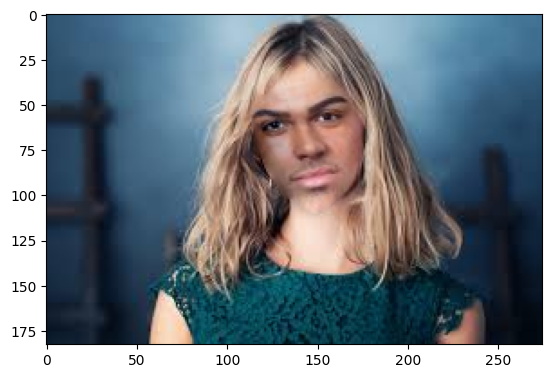

In [4]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

from devlib import *

# Load face mesh model
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)

# main 
# 1. 이미지 로드
frame = cv2.imread("image1.jpg")
img1 = cv2.imread("image2.jpg")

# 2. landmarks detection
points1, img1 = getPoints(img1,cv2.COLOR_BGR2RGB,True)
points2, frame = getPoints(frame,cv2.COLOR_BGR2RGB,True)

img_draw = frame.copy()

# 3. 볼록 선체(convex hull) 구하기 
hullInedx = cv2.convexHull(np.array(points2),returnPoints=False)
hull1 = [points1[int(idx)] for idx in hullInedx]
hull2 = [points2[int(idx)] for idx in hullInedx]
print(hull2)
# 4. 볼록 선체 안 들로네 삼각형 좌표 구하기
triangles = getTriangles(frame,hull2)

# 5. 각 삼각형 좌표로 어핀 변환
for i in range(0,len(triangles)):
    t1 = [hull1[triangles[i][j]] for j in range(3)]
    t2 = [hull2[triangles[i][j]] for j in range(3)]
    warpTriangle(img1,img_draw,t1,t2)
    
# 6. 볼록 선체를 마스크로 써서 얼굴 합성
mask = np.zeros(frame.shape[:2],dtype=frame.dtype)
cv2.fillConvexPoly(mask,np.int32(hull2),(255,255,255))
r = cv2.boundingRect(np.float32(hull2))
center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
output = cv2.seamlessClone(np.uint8(img_draw),frame,mask,center,cv2.NORMAL_CLONE)

plt.imshow(output)
plt.show()

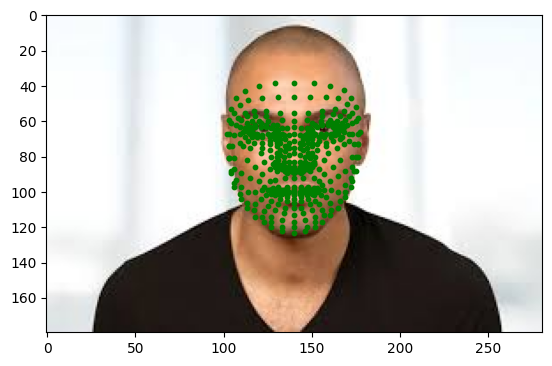

In [4]:
a,img1 = getPoints(img1.copy(),cv2.COLOR_BGR2RGB,return_cvt_img=True)
a = np.array(a)
plt.scatter(a[:,0],a[:,1],s=10,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

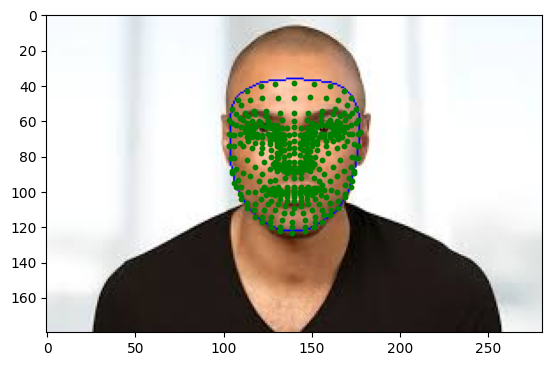

In [6]:
# landmarks
a,img1 = getPoints(img1.copy(),return_cvt_img=True)
# convex hull
a = np.array(a)
hull1 = np.array(hull1)
cv2.drawContours(img1,[hull1],0,(255,0,0),1)
plt.scatter(a[:,0],a[:,1],s=10,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

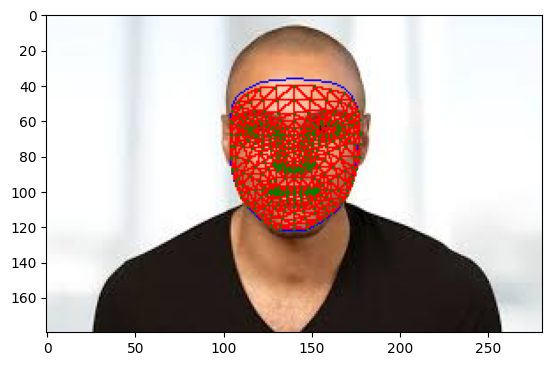

In [7]:
# landmarks
a,img1 = getPoints(img1.copy(),return_cvt_img=True)
# convex hull
cv2.drawContours(img1,[hull1],0,(255,0,0),1)
# delaunay triangulation
h,w = img1.shape[:2]
subdiv = cv2.Subdiv2D((0,0,w,h))
subdiv.insert(a)
triangleList = subdiv.getTriangleList()

for t in triangleList:
    pts = t.reshape(-1,2).astype(np.int32)
    if (pts < 0).sum() or (pts[:,0]>w).sum() or (pts[:,1] > h).sum():
        continue
    cv2.polylines(img1,[pts],True,(0,0,255),1,cv2.LINE_4)


a = np.array(a)
hull1 = np.array(hull1)
plt.scatter(a[:,0],a[:,1],s=1,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()



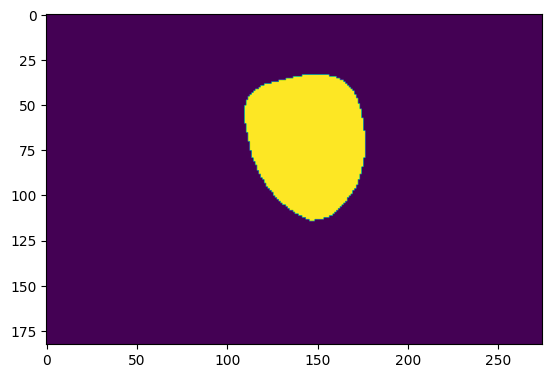

In [8]:
plt.imshow(mask)
plt.show()


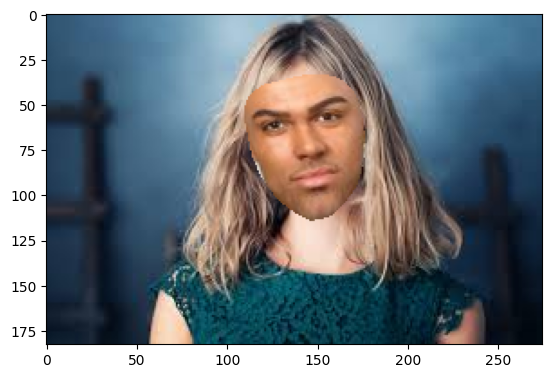

In [9]:
plt.imshow(np.uint8(img_draw))
plt.show()

### Face Alignment

{0: (142, 100), 1: (141, 89), 2: (141, 93), 3: (136, 80), 4: (140, 86), 5: (139, 82), 6: (137, 73), 7: (116, 77), 8: (136, 66), 9: (135, 62), 10: (132, 48), 11: (143, 102), 12: (143, 103), 13: (143, 104), 14: (143, 104), 15: (143, 105), 16: (144, 107), 17: (144, 109), 18: (144, 112), 19: (141, 91), 20: (138, 91), 21: (104, 68), 22: (125, 78), 23: (122, 79), 24: (119, 79), 25: (115, 78), 26: (127, 76), 27: (120, 71), 28: (123, 71), 29: (117, 72), 30: (115, 73), 31: (113, 81), 32: (135, 118), 33: (115, 76), 34: (105, 81), 35: (110, 79), 36: (126, 90), 37: (139, 100), 38: (140, 104), 39: (136, 102), 40: (133, 104), 41: (137, 104), 42: (135, 105), 43: (130, 109), 44: (138, 90), 45: (137, 87), 46: (110, 71), 47: (130, 82), 48: (132, 91), 49: (131, 89), 50: (117, 92), 51: (137, 83), 52: (116, 66), 53: (112, 68), 54: (106, 62), 55: (129, 67), 56: (126, 71), 57: (128, 107), 58: (114, 107), 59: (134, 92), 60: (136, 92), 61: (131, 106), 62: (132, 106), 63: (110, 67), 64: (132, 92), 65: (122, 66)

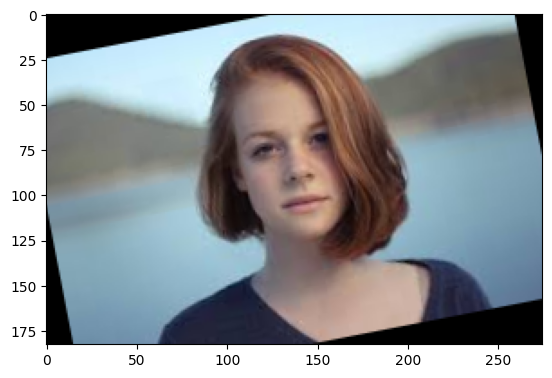

In [111]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np

from devlib import *


mpFaceMesh = mp.solutions.face_mesh

# img1,img2 = imgs_read_rgb('./image.jpg','./image2.jpg')
img1 = imgs_read_rgb('./image.jpg')[0]
img1 = rotate_img(img1,11)
# landmarks1, landmarks2 = imgs_get_landmarks(img1,img2)
idx_to_coordinates,landmarks = get_idx_to_coordinates(img1)
plt.imshow(img1)
print(idx_to_coordinates)

[151.875  68.875] [121.125  75.125]


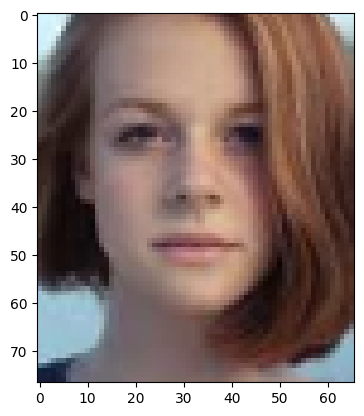

In [112]:
connections = [mpFaceMesh.FACEMESH_LEFT_EYE,mpFaceMesh.FACEMESH_RIGHT_EYE]
left_eye = get_connection_points(idx_to_coordinates,connections[0])
right_eye = get_connection_points(idx_to_coordinates,connections[1])

leftEyeCenter, rightEyeCenter, eyesCenter = get_eye_center(left_eye,right_eye)

print(leftEyeCenter, rightEyeCenter)

angle = get_angle(rightEyeCenter,leftEyeCenter)
scale = 0.7
M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
out_img = cv2.warpAffine(img1, M, (img1.shape[1], img1.shape[0]),
                            flags=cv2.INTER_CUBIC)
out_img = out_img[landmarks[:, 1].min():landmarks[:, 1].max(),
                landmarks[:, 0].min():landmarks[:, 0].max()]
plt.imshow(out_img)
plt.show()


[[ 0.73497227 -0.14938461 46.79946293]
 [ 0.14938461  0.73497227 -1.23431018]]


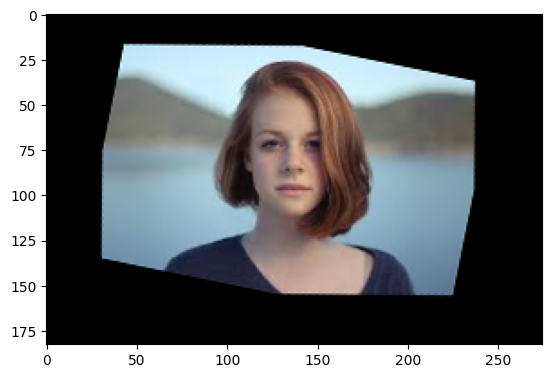

In [113]:

def align(img,idx_to_coordinates,scale):
    connections = [mpFaceMesh.FACEMESH_LEFT_EYE,mpFaceMesh.FACEMESH_RIGHT_EYE]
    left_eye = get_connection_points(idx_to_coordinates,connections[0])
    right_eye = get_connection_points(idx_to_coordinates,connections[1])

    leftEyeCenter, rightEyeCenter, eyesCenter = get_eye_center(left_eye,right_eye)
    angle = get_angle(rightEyeCenter,leftEyeCenter)

    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
    print(M)
    out_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]),
                            flags=cv2.INTER_CUBIC)
    # out_img = out_img[landmarks[:, 1].min():landmarks[:, 1].max(),
    #             landmarks[:, 0].min():landmarks[:, 0].max()]
    plt.imshow(out_img)
    return out_img

img1= align(img1,idx_to_coordinates,0.75)

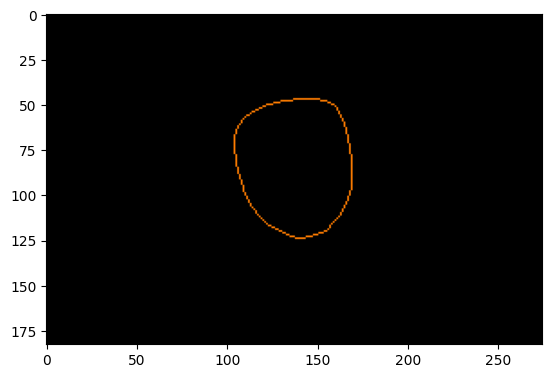

In [105]:

vis_coordinates(img1,idx_to_coordinates,connection=mpFaceMesh.FACEMESH_FACE_OVAL)

### TODO : face morphing

In [ ]:
from devlib import *
import matplotlib.pyplot as plt

img1,img2 = imgs_read_rgb('./image1.jpg','./image2.jpg')

landmarks1, landmarks2 = imgs_get_landmarks(img1,img2)
a = morph_images(img1,img2,landmarks1,landmarks2)
if a is None:
    print('None')
else:
    plt.imshow(a)
    plt.show()
plt.imshow(img1)
plt.show()

In [39]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np

from devlib import *


mpFaceMesh = mp.solutions.face_mesh

# img1,img2 = imgs_read_rgb('./image.jpg','./image2.jpg')
img1 = imgs_read_rgb('./image1.jpg')[0]
img1 = rotate_img(img1,11)
# landmarks1, landmarks2 = imgs_get_landmarks(img1,img2)
idx_to_coordinates,landmarks = get_idx_to_coordinates(img1)
print(idx_to_coordinates)


{0: (143, 87), 1: (139, 81), 2: (141, 82), 3: (134, 73), 4: (138, 79), 5: (137, 75), 6: (134, 65), 7: (118, 69), 8: (132, 58), 9: (130, 54), 10: (126, 41), 11: (144, 88), 12: (144, 88), 13: (145, 88), 14: (146, 90), 15: (146, 91), 16: (146, 92), 17: (147, 93), 18: (148, 95), 19: (140, 82), 20: (138, 82), 21: (108, 60), 22: (126, 68), 23: (124, 69), 24: (121, 70), 25: (118, 70), 26: (128, 67), 27: (120, 63), 28: (123, 62), 29: (117, 64), 30: (116, 66), 31: (117, 72), 32: (141, 101), 33: (117, 68), 34: (112, 71), 35: (114, 70), 36: (127, 80), 37: (140, 87), 38: (142, 89), 39: (137, 88), 40: (136, 89), 41: (139, 89), 42: (138, 90), 43: (135, 93), 44: (137, 82), 45: (135, 79), 46: (112, 64), 47: (130, 72), 48: (132, 81), 49: (132, 79), 50: (120, 82), 51: (135, 76), 52: (116, 60), 53: (113, 62), 54: (108, 56), 55: (126, 59), 56: (125, 63), 57: (132, 91), 58: (125, 91), 59: (134, 82), 60: (137, 82), 61: (134, 90), 62: (135, 90), 63: (111, 61), 64: (133, 82), 65: (120, 59), 66: (118, 57), 67:

[[  0.69962393  -0.27023389  57.03503642]
 [  0.27023389   0.69962393 -18.15863474]]


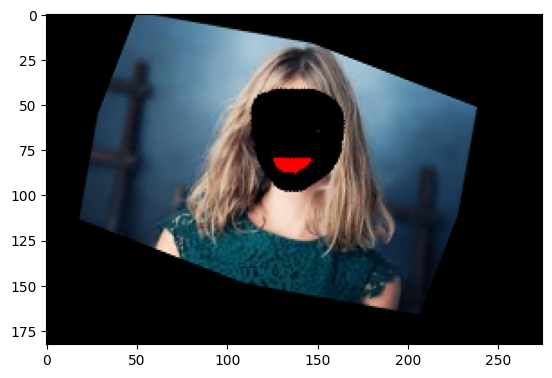

In [40]:

def align(img,idx_to_coordinates,scale):
    connections = [mpFaceMesh.FACEMESH_LEFT_EYE,mpFaceMesh.FACEMESH_RIGHT_EYE]
    left_eye = get_connection_points(idx_to_coordinates,connections[0])
    right_eye = get_connection_points(idx_to_coordinates,connections[1])

    leftEyeCenter, rightEyeCenter, eyesCenter = get_eye_center(left_eye,right_eye)
    angle = get_angle(rightEyeCenter,leftEyeCenter)

    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
    print(M)
    out_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]),
                            flags=cv2.INTER_CUBIC)
    # out_img = out_img[landmarks[:, 1].min():landmarks[:, 1].max(),
    #             landmarks[:, 0].min():landmarks[:, 0].max()]
    # plt.imshow(out_img)
    return out_img
def _get_masked_frame(frame,idx_to_coordinates,connection=mpFaceMesh.FACEMESH_LEFT_EYE,color=(0,0,0),thickness=8):
    # mask = np.zeros(frame.shape[:2],dtype=frame.dtype)
    # cv2.fillConvexPoly(mask,np.int32(get_connection_points(idx_to_coordinates,connection)),(255,255,255))
    # frame = cv2.bitwise_and(frame,frame,mask=mask)
    cv2.drawContours(frame,[get_connection_points(idx_to_coordinates,connection)],0,color,thickness)
    return frame


img1= align(img1,idx_to_coordinates,0.75)
plt.imshow(img1)

In [42]:
from moviepy.editor import VideoFileClip

VideoFileClip('./faceAlignment.gif').speedx(0.5).write_gif('faceAlignment.gif')

MoviePy - Building file faceAlignment.gif with imageio.
